## **Multi-Agent Retail Inventory and Pricing Optimization Framework**

- Each product has its own agent making pricing/inventory decisions
- Agents compete for shared warehouse capacity
- The environment tracks global constraints and mediates interactions

In [ ]:
pip install scikit-optimize

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
from collections import deque
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import differential_evolution
# from bayes_opt import BayesianOptimization
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple

In [26]:
df = pd.read_csv("/content/retail_price.csv")
df.head(2)

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.0,4.4,8.760,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.0,4.4,21.322,45.95,4.0,12.933333,45.95


## **Data preparation**

In [27]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    """weekly product data with demand-weighted reference prices"""
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:

                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

products_data = prepare_weekly_data(df, min_weeks=4, date_col='month_year')

Prepared data for 28 products (min 4 weeks)


/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping co

## **Adaptive single product**

In [28]:
class AdaptiveSingleProductEnv:
    def __init__(self,
                 demand_series: List[int],
                 price_series: List[float],
                 ref_price: float,
                 init_inventory: int = 60,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 service_weight: float = 10.0,
                 max_order: int = 200):


        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.price_series = [max(0.1, float(p)) for p in price_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = min(len(self.original_demand), len(self.price_series))
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks - 1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self.service_weight = float(service_weight)
        self.max_order = max(0, int(max_order))

        self.reset()

    def reset(self):
        """Reset environment while maintaining configuration"""
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.pending_orders = []
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        """Get current environment state"""
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week + 1]) if self.current_week > 0 else 0}

    def step(self, order_qty: int = 0) -> float:
        """Execute one week with proper lead time handling"""
        if self.current_week >= self.weeks:
            return 0.0

        try:
            self._process_order_arrivals()

            price = self.price_series[self.current_week]
            demand = self._calculate_demand(price)

            sales_qty = self._calculate_sales(demand)
            profit = self._calculate_profit(price, sales_qty, demand, order_qty)

            self._update_inventory(sales_qty, order_qty)
            self._record_stats(price, order_qty, demand, sales_qty, profit)

            self.current_week += 1
            return profit + self.service_weight * (sales_qty / max(demand, 1))

        except Exception as e:
            print(f"Error in step: {str(e)}")
            return 0.0

    def _process_order_arrivals(self):
        """Process orders that arrive this week"""
        arrivals = sum(qty for (week, qty) in self.pending_orders
                    if week == self.current_week)
        self.inventory += arrivals
        self.pending_orders = [
            (week, qty) for (week, qty) in self.pending_orders
            if week > self.current_week]

    def _calculate_demand(self, price: float) -> int:
        """Calculate demand with price elasticity and noise"""
        base_demand = self.original_demand[self.current_week]
        price_factor = (price / self.ref_price) ** self.elasticity
        noise = np.random.normal(0, 0.1 * base_demand)
        return max(1, int(base_demand * price_factor + noise))

    def _calculate_sales(self, demand: int) -> int:
        """Calculate actual sales considering inventory"""
        available = max(self.inventory - self.safety_stock, 0)
        return min(available, demand)

    def _calculate_profit(self, price: float, sales: int,
                         demand: int, order_qty: int) -> float:
        """Calculate all profit components"""
        revenue = sales * price
        holding_cost = self.inventory * self.holding_rate
        stockout_cost = max(demand - sales, 0) * self.stockout_penalty
        order_cost = order_qty * self.order_cost
        return revenue - holding_cost - stockout_cost - order_cost

    def _update_inventory(self, sales_qty: int, order_qty: int):
        """Update inventory and pending orders"""
        self.inventory = max(0, self.inventory - sales_qty)
        if order_qty > 0:
            arrival_week = self.current_week + self.lead_time
            self.pending_orders.append(
                (arrival_week, min(order_qty, self.max_order)))

    def _record_stats(self, price: float, order_qty: int,
                    demand: int, sales_qty: int, profit: float):
        """Record weekly performance metrics"""
        self.weekly_stats.append({
            'week': self.current_week,
            'price': price,
            'order_qty': order_qty,
            'demand': demand,
            'sales': sales_qty,
            'inventory': self.inventory,
            'profit': profit,
            'service_level': sales_qty / max(demand, 1)})
        self.total_profit += profit
        self.total_demand += demand
        self.total_sales += sales_qty

    def service_level(self) -> float:
        """Calculate cumulative service level"""
        return self.total_sales / self.total_demand if self.total_demand > 0 else 0.0

    def run_adaptive_policy(self) -> List[Dict]:
        """Run with improved adaptive ordering policy"""
        self.reset()
        for _ in range(self.weeks):
            if self.current_week == 0:
                forecast = self.original_demand[0]
            else:
                prev_demand = self.original_demand[self.current_week - 1]
                forecast = 0.3 * prev_demand + 0.7 * (
                    self.weekly_stats[-1]['demand'] if self.weekly_stats else prev_demand)

            pending_qty = sum(qty for (week, qty) in self.pending_orders)
            target = forecast + self.safety_stock
            order_qty = max(0, min(
                target - self.inventory - pending_qty,
                self.max_order))

            self.step(order_qty=order_qty)

        return self.weekly_stats

## **Trade-off between Service Level and Total Profit (bed1)**

Testing weight 20.0: 100%|██████████| 30/30 [00:00<00:00, 11532.32it/s]


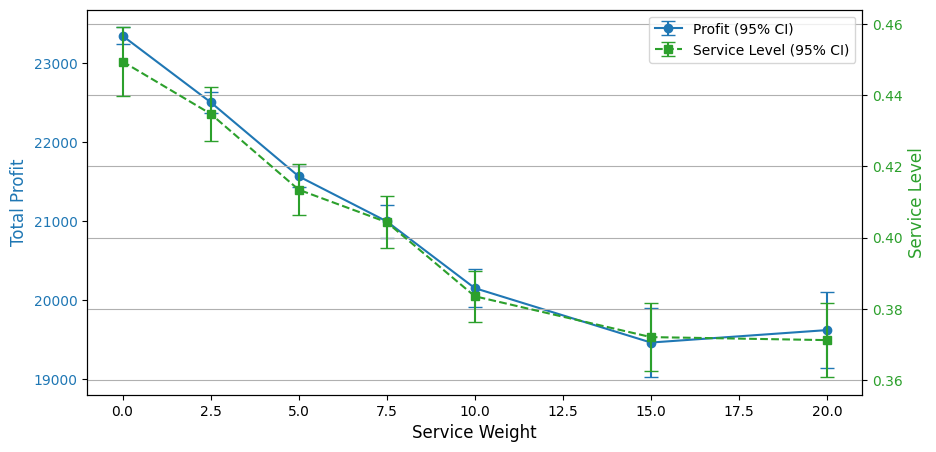


Profit variability across trials:
               0.0           2.5           5.0           7.5           10.0  \
count     30.000000     30.000000     30.000000     30.000000     30.000000   
mean   23350.478784  22509.489316  21570.331903  20999.628828  20153.980537   
std      308.047820    382.978477    381.496258    602.861798    679.030564   
min    22777.917928  21719.100857  21027.247643  19964.470571  19273.477000   
25%    23162.628303  22204.887571  21390.539607  20692.963125  19739.628518   
50%    23272.953481  22509.167321  21448.608607  20793.564107  20062.736535   
75%    23550.366231  22820.679232  21785.246178  21133.987018  20339.507462   
max    23897.306142  23199.981500  22556.057012  22446.095045  21893.930404   

               15.0          20.0  
count     30.000000     30.000000  
mean   19464.786697  19622.541012  
std     1248.632350   1367.621366  
min    17583.783571  16710.198098  
25%    18373.643803  18678.632363  
50%    19233.990279  19699.618033  
7

In [29]:
from tqdm import tqdm

def simulate_policy_multiple_trials(env_class, demand_series, price_series, ref_price,
                                  service_weights, n_trials=30, order_qty=0):
    """
    Run multiple trials of the policy simulation and return aggregated results

    """
    results = {
        'service_weights': service_weights,
        'profits': np.zeros((len(service_weights), n_trials)),
        'service_levels': np.zeros((len(service_weights), n_trials))}

    for i, weight in enumerate(service_weights):
        for trial in tqdm(range(n_trials), desc=f"Testing weight {weight}"):
            env = env_class(
                demand_series=demand_series,
                price_series=price_series,
                ref_price=ref_price,
                service_weight=weight,
                safety_stock=int(weight),)
            env.run_adaptive_policy()
            results['profits'][i, trial] = env.total_profit
            results['service_levels'][i, trial] = env.service_level()

    return results

def plot_tradeoff_with_ci(results, n_trials):
    """Plot trade-off with confidence intervals"""
    fig, ax1 = plt.subplots(figsize=(10, 5))
    profit_mean = np.mean(results['profits'], axis=1)
    profit_se = np.std(results['profits'], axis=1) / np.sqrt(n_trials)

    service_mean = np.mean(results['service_levels'], axis=1)
    service_se = np.std(results['service_levels'], axis=1) / np.sqrt(n_trials)

    # Plot profit with CI
    ax1.errorbar(results['service_weights'], profit_mean, yerr=1.96*profit_se,
                 fmt='-o', color='tab:blue', capsize=5, label='Profit (95% CI)')
    ax1.set_xlabel('Service Weight', fontsize=12)
    ax1.set_ylabel('Total Profit', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot service level with CI
    ax2 = ax1.twinx()
    ax2.errorbar(results['service_weights'], service_mean, yerr=1.96*service_se,
                 fmt='--s', color='tab:green', capsize=5, label='Service Level (95% CI)')
    ax2.set_ylabel('Service Level', color='tab:green', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:green')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # plt.title(f"Trade-off Between Service Level and Profit (n={n_trials} trials)")
    plt.grid(True)
    plt.show()

if products_data:
    sample_product_id = list(products_data.keys())[0]
    demand_series, price_series, ref_price = products_data[sample_product_id]

    service_weights = [0.0, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0]
    n_trials = 30

    trial_results = simulate_policy_multiple_trials(
        env_class=AdaptiveSingleProductEnv,
        demand_series=demand_series,
        price_series=price_series,
        ref_price=ref_price,
        service_weights=service_weights,
        n_trials=n_trials)

    plot_tradeoff_with_ci(trial_results, n_trials)

    print("\nProfit variability across trials:")
    print(pd.DataFrame(trial_results['profits'].T, columns=service_weights).describe())


## **MULTI-PRODUCT ENVIRONMENT**

In [30]:
class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 800,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.base_capacity = warehouse_capacity  # Store the original capacity
        self.warehouse_capacity = random.uniform(0.9, 1.1) * self.base_capacity # Use self.base_capacity

        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0

        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []

        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float),
            'product_service_levels': {}}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': AdaptiveSingleProductEnv(demand_series, price_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price / 15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")

        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week.clear()
        self.weekly_warehouse_utilization = []
        self.metrics['shared_costs_total'] = 0
        self.metrics['over_utilization_penalties'] = 0
        self.metrics['cumulative_rewards'] = defaultdict(float)

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []

        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required']
                             for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0


    def step(self, actions: Dict[str, Tuple[float, int]]):
        if self.current_week >= max(len(data['env'].original_demand) for data in self.products.values()):
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue

            product_data = self.products[product_id]
            env = product_data['env']

            reward = env.step(order_qty=order_qty)
            shared_cost_reduction = self.shared_transport_cost
            total_reward = reward + shared_cost_reduction

            individual_rewards[product_id] = total_reward
            self.metrics['cumulative_rewards'][product_id] += total_reward

        if len(actions) > 0:
             self.shared_shipment_count += 1
             self.metrics['shared_costs_total'] += self.shared_transport_cost * len(actions)


        self._process_order_arrivals()

        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty


        self.current_week += 1
        done = self.current_week >= max(len(data['env'].original_demand) for data in self.products.values())

        return self.get_global_state(), individual_rewards, done, {}


    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0

        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']

        used_space = sum(data['inventory'] * data['space_required']
                         for data in self.products.values())
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space // space_per_unit
        return min(requested_qty, max_possible)

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived = sum(qty for week, qty in product_data['pending_orders']
                          if week == self.current_week)
            product_data['inventory'] += arrived
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

/tmp/ipython-input-31-2170855655.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(products, fontsize=12, rotation=75)
/tmp/ipython-input-31-2170855655.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(products, fontsize=12, rotation=75)


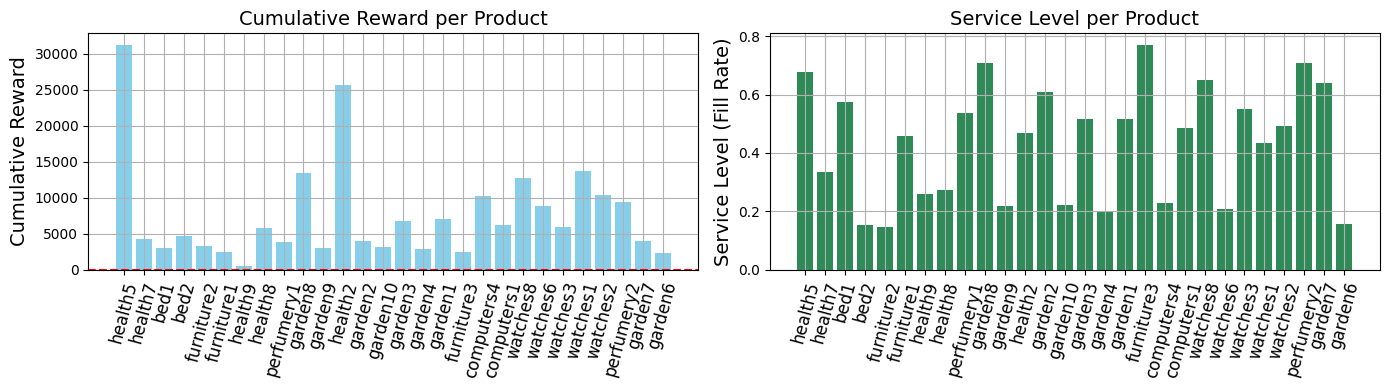

In [31]:
def plot_cumulative_rewards(ax, cumulative_rewards):
    products = list(cumulative_rewards.keys())
    rewards = list(cumulative_rewards.values())

    ax.bar(products, rewards, color='skyblue')
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xticklabels(products, fontsize=12, rotation=75)
    ax.set_ylabel('Cumulative Reward', fontsize=14)
    ax.set_title('Cumulative Reward per Product', fontsize=14)
    ax.grid()

def plot_service_levels(ax, product_service_levels):
    products = list(product_service_levels.keys())
    service_levels = list(product_service_levels.values())

    ax.bar(products, service_levels, color='seagreen')
    ax.set_xticklabels(products, fontsize=12, rotation=75)
    ax.set_ylabel('Service Level (Fill Rate)', fontsize=14)
    ax.set_title('Service Level per Product', fontsize=14)
    ax.grid()

multi_env = MultiProductRetailEnv(products_data)

num_weeks_to_simulate = 10

for _ in range(num_weeks_to_simulate):

    actions = {product_id: (0, 10) for product_id in multi_env.products.keys()}
    global_state, individual_rewards, done, info = multi_env.step(actions)
    if done:
        break

summary = multi_env.summarize()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_cumulative_rewards(axes[0], summary['cumulative_rewards'])
plot_service_levels(axes[1], summary['product_service_levels'])

plt.tight_layout()
plt.show()

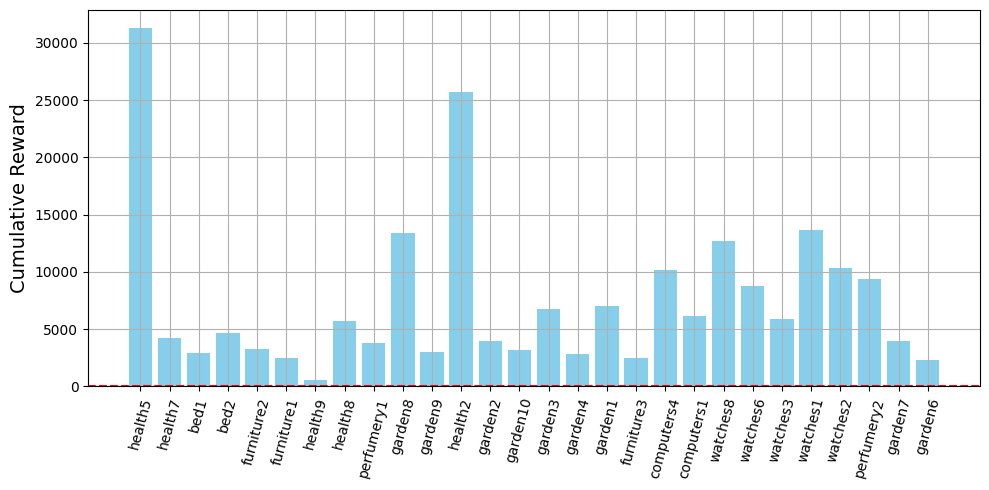

In [32]:
def plot_cumulative_rewards(ax, cumulative_rewards):
    products = list(cumulative_rewards.keys())
    rewards = list(cumulative_rewards.values())

    ax.bar(products, rewards, color='skyblue')
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xticks(np.arange(len(products)))
    ax.set_xticklabels(products, fontsize=10, rotation=75)
    ax.set_ylabel('Cumulative Reward', fontsize=14)
    # ax.set_title('Cumulative Reward per Product', fontsize=14)
    ax.grid()

fig, ax = plt.subplots(figsize=(10, 5))
plot_cumulative_rewards(ax, summary['cumulative_rewards'])

plt.tight_layout()
plt.show()

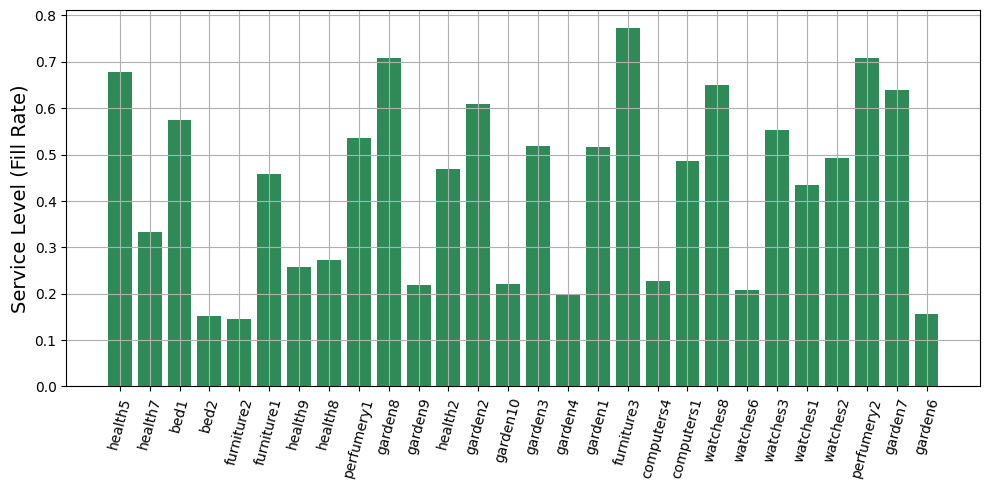

In [33]:
def plot_service_levels(ax, product_service_levels):
    products = list(product_service_levels.keys())
    service_levels = list(product_service_levels.values())

    ax.bar(products, service_levels, color='seagreen')
    ax.set_xticks(np.arange(len(products)))
    ax.set_xticklabels(products, fontsize=10, rotation=75)
    ax.set_ylabel('Service Level (Fill Rate)', fontsize=14)
    # ax.set_title('Service Level per Product', fontsize=14)
    ax.grid()

fig, ax = plt.subplots(figsize=(10, 5))

plot_service_levels(ax, summary['product_service_levels'])

plt.tight_layout()
plt.show()

## **OptimizedProductAgent - DQN based RL agent to learn optimal pricing and ordering strategies in the environment**

In [34]:
class OptimizedProductAgent(nn.Module):
    def __init__(self, input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.001):
        super().__init__()
        self.price_bins = None
        self.order_bins = None
        self.action_size = price_bins * order_bins

        # Network architecture
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 128
        self.target_update_freq = 50
        self.steps = 0

        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        """Update target network to match current network weights"""
        self.target_net.load_state_dict(self.net.state_dict())

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict, price_bins: np.ndarray, order_bins: np.ndarray) -> Tuple[float, int]:
        self.price_bins = price_bins
        self.order_bins = order_bins

        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(price_bins)-1)
            order_idx = random.randint(0, len(order_bins)-1)
            return price_bins[price_idx], order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(len(price_bins), len(order_bins))
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // len(order_bins)
            order_idx = max_idx % len(order_bins)

        return price_bins[price_idx], order_bins[order_idx]

    def remember(self, state, action, reward, next_state):
        price, order = action
        price_idx = np.argmin(np.abs(self.price_bins - price))
        order_idx = np.argmin(np.abs(self.order_bins - order))
        action_idx = price_idx * len(self.order_bins) + order_idx
        self.memory.append((state, action_idx, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, action_indices, rewards, next_states = zip(*batch)

        state_tensors = torch.FloatTensor([
            [s['inventory'], s['demand'], s['avg_demand'],
            s['global']['warehouse_utilization'],
            s['global']['current_week']/52]
            for s in states])

        next_state_tensors = torch.FloatTensor([
            [ns['inventory'], ns['demand'], ns['avg_demand'],
            ns['global']['warehouse_utilization'],
            ns['global']['current_week']/52] if ns is not None else [0,0,0,0,0]
            for ns in next_states])

        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


## **OPTIMIZED multi agent COORDINATOR**

In [35]:
class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.price_bins = {}
        self.order_bins = {}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.price_bins[product_id] = np.linspace(
                max(0.1, ref_price * 0.6),
                ref_price * 1.4,12)


            avg_demand = np.mean(demand_series)
            self.order_bins[product_id] = np.linspace(
                0,
                max(50, avg_demand * 3),13)

            # DQN agent
            self.agents[product_id] = OptimizedProductAgent(
                price_bins=len(self.price_bins[product_id]),
                order_bins=len(self.order_bins[product_id]))


    def train(self, episodes: int = 1000):
        """Train all agents with enhanced exploration"""
        rewards_history = {product_id: [] for product_id in self.agents.keys()}
        episode_length = len(next(iter(self.env.products.values()))['env'].original_demand)

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_rewards = defaultdict(float)

            while not done:
                actions = {}
                for product_id, agent in self.agents.items():
                    if product_id not in self.env.products:
                        continue

                    product_state = {
                        **self.env.products[product_id]['env']._get_state(),
                        'global': state}
                    price, order_qty = agent.get_action(
                        product_state,
                        self.price_bins[product_id],
                        self.order_bins[product_id])
                    actions[product_id] = (price, order_qty)

                next_state, rewards, done, _ = self.env.step(actions)

                for product_id, reward in rewards.items():
                    if product_id not in self.agents:
                        continue

                    product_state = {
                        **self.env.products[product_id]['env']._get_state(),
                        'global': state}
                    next_product_state = {
                        **self.env.products[product_id]['env']._get_state(),
                        'global': next_state
                    } if not done else None

                    self.agents[product_id].remember(
                        product_state,
                        actions[product_id],
                        reward,
                        next_product_state)
                    episode_rewards[product_id] += reward

                for agent in self.agents.values():
                    agent.replay()

                state = next_state

            for product_id, reward in episode_rewards.items():
                rewards_history[product_id].append(reward / episode_length)

            if (episode + 1) % 100 == 0:
                avg_rewards = {k: np.mean(v[-100:]) for k, v in rewards_history.items()}
                print(f"\nEpisode {episode+1}/{episodes}")
                print(f"Current ε: {self.agents[next(iter(self.agents))].epsilon:.3f}")
                print("Average Normalized Rewards (last 100):")
                for product_id, reward in avg_rewards.items():
                    print(f"  {product_id}: {reward:.2f}")

        return rewards_history, self.env

    def evaluate(self, greedy: bool = True):
        """Evaluate trained agents"""
        if not self.agents:
            raise ValueError("No agents initialized")

        state = self.env.reset()
        done = False
        results = {}

        while not done:
            actions = {}
            for product_id, agent in self.agents.items():
                if product_id not in self.env.products:
                    continue

                product_state = {
                    **self.env.products[product_id]['env']._get_state(),
                    'global': state}

                if greedy:
                    original_epsilon = agent.epsilon
                    agent.epsilon = 0

                price, order_qty = agent.get_action(
                    product_state,
                    self.price_bins[product_id],
                    self.order_bins[product_id])

                if greedy:
                    agent.epsilon = original_epsilon

                actions[product_id] = (price, order_qty)

            state, _, done, _ = self.env.step(actions)

        for product_id in self.agents.keys():
            if product_id not in self.env.products:
                continue

            env = self.env.products[product_id]['env']
            results[product_id] = {
                'total_profit': env.total_profit,
                'service_level': env.service_level(),
                'total_sales': env.total_sales,
                'total_demand': env.total_demand,
                'final_inventory': env.inventory,
                'weekly_stats': env.weekly_stats}

        return results

## **REPORTING**

In [36]:
def generate_performance_report(results, env):
    """Generate comprehensive performance report"""
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w['service_level'] < 0.5)
        avg_service = np.mean([w['service_level'] for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels),
            'min_inventory': min(inventory_levels),
            'avg_service': avg_service,
            'avg_demand': np.mean([w['demand'] for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]}
            for pid, stats in results.items()}}
    return report

## **Visualization**

In [37]:
def create_visualizations(report, rewards_history, env):
    """Generate enhanced visualizations"""

    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Profit Distribution
    ax1 = axes[0, 0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color = 'k')
    ax1.set_title('Weekly Profit by Product', fontsize=12)
    ax1.set_ylabel('Profit ($)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # Service Level
    ax2 = axes[0, 1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=12)
    ax2.set_ylabel('Service Level', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1.0)

    # Training Progress
    ax3 = axes[1, 0]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(),
                label=pid, color=colors[i])
    ax3.set_title('Training Progress (50-Episode MA)', fontsize=12)
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Normalized Reward', fontsize=12)
    # ax3.legend()
    ax3.grid()

    # Warehouse Utilization
    ax4 = axes[1, 1]
    ax4.plot(env.weekly_warehouse_utilization,
            label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=12)
    ax4.set_xlabel('Week', fontsize=12)
    ax4.set_ylabel('Utilization (%)', fontsize=12)
    ax4.legend()
    ax4.grid()


    plt.tight_layout()
    plt.show()

/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
/tmp/ipython-input-27-3129787822.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping co

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data

Episode 100/1000
Current ε: 0.154
Average Normalized Rewards (last 100):
  health5: 10537.48
  health7: 2518.30
  bed1: 1080.55
  bed2: 3001.09
  furniture2: 5395.73
  furniture1: 1129.15
  health9: 664.00
  health8: 3921.39
  perfumery1: 1372.67
  garden8: 3946.40
  garden9: 3427.00
  health2: 12223.37
  garden2: 1236.51
  garden10: 2657.87
  garden3: 2663.16
  garden4: 2819.16
  garden1: 2723.80
  furniture3: 623.15
  computers4: 6676.25
  computers1: 2344.94
  watches8: 3616.57
  watches6: 6636.70
  watches3: 2376.82
  watches1: 5769.11
  watches2: 3884.51
  perfumery2: 2400.74
  garden7: 1160.88
  garden6: 3303.97

Episode 200/1000
Current ε: 0.050
Average Normalized Rewards (last 100):
  health5: 10723.52
  health7: 2672.05
  bed1: 1133.63
  bed2: 4350.25
  furniture2: 6105.85
  furniture1: 1196.22
  health9: 769.25
  health8: 4303.28
  perfumery1: 1500.00
  garden8: 4024.89
  garden9: 3926

/tmp/ipython-input-37-4242104008.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(products)).colors


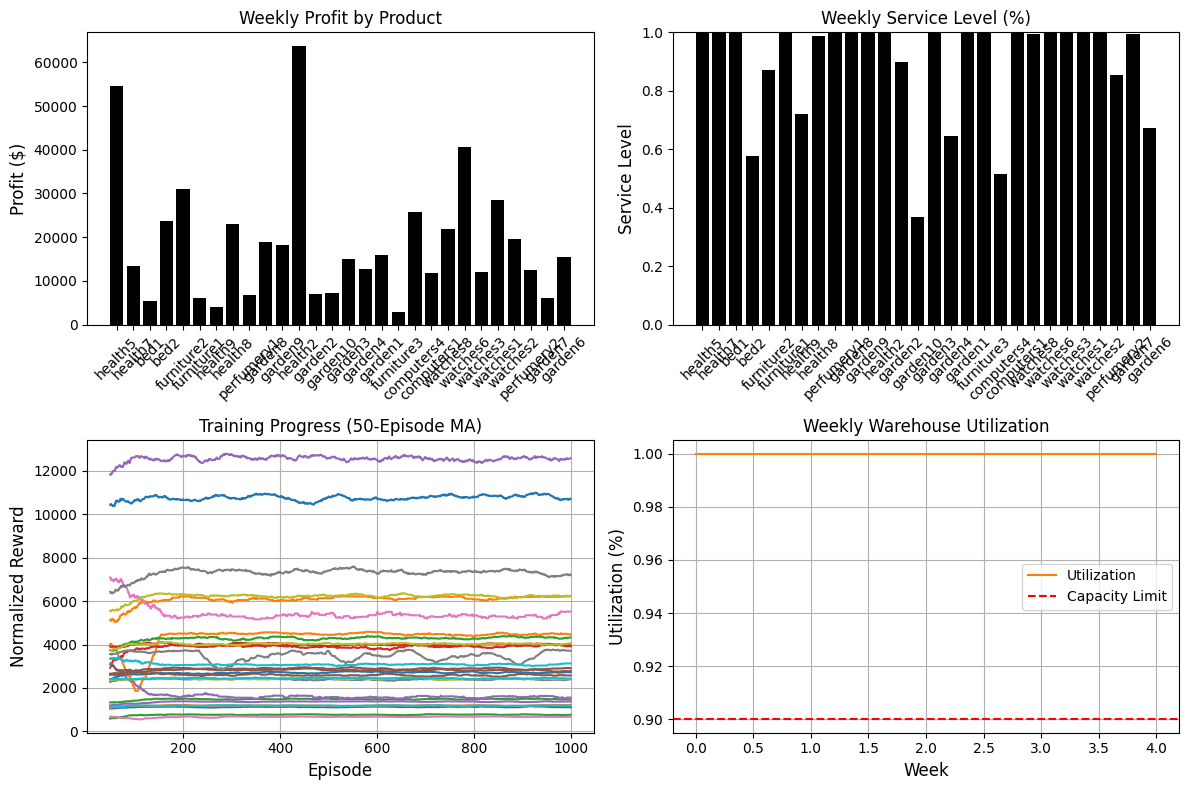

Report saved to retail_optimization_report.pkl


In [38]:
import pickle
from datetime import datetime

def generate_performance_report(results, env):
    """Generate comprehensive performance report"""
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w['service_level'] < 0.5)
        avg_service = np.mean([w['service_level'] for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels),
            'min_inventory': min(inventory_levels),
            'avg_service': avg_service,
            'avg_demand': np.mean([w['demand'] for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count, # Added shared_shipments here
            'shared_costs_total': env.metrics['shared_costs_total'], # Added shared_costs_total here
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]}
            for pid, stats in results.items()}}
    return report

def generate_executive_summary(report):
    """Generate professional executive summary"""
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f}) # Corrected key and used shared_costs_total


    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    # Generate dynamic recommendations
    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def generate_full_report(env, rewards_history):
    """Generate complete report package"""
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    """Save report object to file"""
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    """Load report object from file"""
    with open(filename, 'rb') as f:
        return pickle.load(f)

if __name__ == "__main__":
    products_data = prepare_weekly_data(df, min_weeks=4)
    if not products_data:
        print("No valid products found. Exiting.")
        exit()

    print(f"\nFound {len(products_data)} products with sufficient weekly data")
    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env)

    save_report(full_report)

    def export_key_tables(report):
        product_data = []
        for pid, stats in report['performance_metrics']['product_breakdown'].items():
            product_data.append({
                'product_id': pid,
                'total_profit': stats['total_profit'],
                'avg_service_level': stats['avg_service'],
                'avg_inventory': stats['avg_inventory'],
                'inventory_turns': stats['inventory_turnover'],
                'stockout_weeks': stats['stockout_weeks'],
                'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
        pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

    export_key_tables(full_report)

In [39]:
# plt.scatter(df['avg_inventory'], df['total_profit'])
# plt.xlabel("Average Inventory Level")
# plt.ylabel("Total Profit")
# plt.title("Inventory-Profit Tradeoff in MARL System")
# plt.show()

## **Ablation**

In [41]:
print(products_data.keys())

dict_keys(['health5', 'health7', 'bed1', 'bed2', 'furniture2', 'furniture1', 'health9', 'health8', 'perfumery1', 'garden8', 'garden9', 'health2', 'garden2', 'garden10', 'garden3', 'garden4', 'garden1', 'furniture3', 'computers4', 'computers1', 'watches8', 'watches6', 'watches3', 'watches1', 'watches2', 'perfumery2', 'garden7', 'garden6'])


In [ ]:
# ablation_study.py

from copy import deepcopy
from collections import defaultdict
import numpy as np
from tqdm import tqdm

# Assumes you have: OptimizedMultiAgentCoordinator, OptimizedProductAgent, AdaptiveSingleProductEnv, MultiProductRetailEnv
# You must import or define them before running this ablation script


def run_independent_agents(products_data, episodes=100):
    """Ablation A1: Independent single-product agents (no MARL)"""
    results = {}
    for product_id, (demand, price, ref_price) in products_data.items():
        env = AdaptiveSingleProductEnv(demand, price, ref_price)
        price_bins = np.linspace(max(0.1, ref_price * 0.6), ref_price * 1.4, 12)
        order_bins = np.linspace(0, max(50, np.mean(demand) * 3), 13)

        agent = OptimizedProductAgent(
            price_bins=len(price_bins),
            order_bins=len(order_bins))

        for _ in range(episodes):
            env.reset()
            done = False
            while not done:
                state = env._get_state()
                state['global'] = {'warehouse_utilization': 0.5, 'current_week': env.current_week / 52}
                price, order = agent.get_action(state, price_bins, order_bins)
                env.step(order_qty=order)
        results[product_id] = {
            'total_profit': env.total_profit,
            'service_level': env.service_level(),
            'final_inventory': env.inventory}
    return results


def run_marl_variant(products_data, ablate: str = None, episodes: int = 200):
    """
    Run MARL with optional ablations.
    ablate: One of [None, 'no_global', 'fixed_bins', 'no_target', 'no_decay', 'no_shared_cost', 'no_penalty']
    """
    products_data = deepcopy(products_data)
    env = MultiProductRetailEnv(products_data)

    for product_id in env.products:
        env.products[product_id]['env'].reset()

    agents = {}
    price_bins = {}
    order_bins = {}

    for product_id, (demand_series, price_series, ref_price) in products_data.items():
        price_bins[product_id] = (np.linspace(10, 20, 12)
                                  if ablate == 'fixed_bins'
                                  else np.linspace(max(0.1, ref_price * 0.6), ref_price * 1.4, 12))

        avg_demand = np.mean(demand_series)
        order_bins[product_id] = (np.linspace(0, 200, 13)
                                  if ablate == 'fixed_bins'
                                  else np.linspace(0, max(50, avg_demand * 3), 13))

        agent = OptimizedProductAgent(
            price_bins=len(price_bins[product_id]),
            order_bins=len(order_bins[product_id]))

        if ablate == 'no_target':
            agent._update_target_net = lambda: None

        if ablate == 'no_decay':
            agent.epsilon_decay = 1.0

        agents[product_id] = agent

    for _ in tqdm(range(episodes)):
        state = env.reset()
        done = False
        while not done:
            actions = {}
            for product_id, agent in agents.items():
                s = env.products[product_id]['env']._get_state()
                if ablate != 'no_global':
                    s['global'] = state
                else:
                    s['global'] = {'warehouse_utilization': 0.5, 'current_week': 0.5}

                price, order = agent.get_action(s, price_bins[product_id], order_bins[product_id])
                actions[product_id] = (price, order)

            if ablate == 'no_shared_cost':
                env.shared_transport_cost = 0
            if ablate == 'no_penalty':
                env.metrics['over_utilization_penalties'] = 0

            next_state, rewards, done, _ = env.step(actions)

            for product_id, reward in rewards.items():
                s = env.products[product_id]['env']._get_state()
                s['global'] = state if ablate != 'no_global' else {'warehouse_utilization': 0.5, 'current_week': 0.5}
                ns = env.products[product_id]['env']._get_state()
                ns['global'] = next_state
                agent.remember(s, actions[product_id], reward, ns)
                agent.replay()

            state = next_state

    summary = env.summarize()
    return summary


if __name__ == "__main__":


    configs = [
        ("Full MARL", None),
        ("No Global State", "no_global"),
        ("Fixed Bins", "fixed_bins"),
        ("No Target Net", "no_target"),
        ("No Epsilon Decay", "no_decay"),
        ("No Shared Cost", "no_shared_cost"),
        ("Independent Agents", "independent")]

    results = {}
    for name, ablate in configs:
        if ablate == "independent":
            r = run_independent_agents(products_data, episodes=100)
        else:
            r = run_marl_variant(products_data, ablate=ablate, episodes=200)
        results[name] = r

    import json
    with open("ablation_results.json", "w") as f:
        json.dump(results, f, indent=2)

    print("Ablation study complete. Results saved.")

100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


In [ ]:
pip install pygad

In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from scipy.optimize import differential_evolution
import torch
import torch.nn as nn
import torch.optim as optim
import random
from typing import Dict, Tuple, List
from collections import defaultdict

# Environment
class RetailEnv:
    def __init__(self, demand_series, ref_price, init_inventory=100, lead_time=2,
                 elasticity=-0.8, holding_rate=0.1, stockout_penalty=1.0,
                 order_cost=0.5, z_score=1.28):
        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks - 1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.z_score = max(0.0, float(z_score))

        if self.weeks > self.lead_time:
            lead_time_demands = [sum(self.original_demand[i:i+self.lead_time])
                               for i in range(len(self.original_demand) - self.lead_time)]
            self.std_demand_lead_time = np.std(lead_time_demands)
        else:
            self.std_demand_lead_time = np.std(self.original_demand)

        self.reset()

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.pending_orders = []
        self.stockouts = 0
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        return self

    def step(self, price):
        if self.current_week >= self.weeks:
            return 0

        base_demand = self.original_demand[self.current_week]
        demand = max(1, base_demand * (max(0.1, price) / self.ref_price) ** self.elasticity)

        forecasted_demand = demand * self.lead_time
        safety_stock = self.z_score * self.std_demand_lead_time
        target_inventory_level = forecasted_demand + safety_stock
        order_qty = max(0, round(target_inventory_level - self.inventory))

        sales_qty = min(self.inventory, demand)
        revenue = sales_qty * price
        holding_cost = self.inventory * self.holding_rate
        stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
        order_cost = order_qty * self.order_cost

        profit = revenue - holding_cost - stockout_cost - order_cost
        self.total_profit += profit
        self.inventory -= sales_qty

        if order_qty > 0:
            self.pending_orders.append((self.current_week + self.lead_time, order_qty))

        arrived = sum(q for t, q in self.pending_orders if t == self.current_week)
        self.inventory += arrived
        self.pending_orders = [(t, q) for t, q in self.pending_orders if t > self.current_week]

        self.stockouts += max(0, demand - sales_qty)
        self.total_sales += sales_qty
        self.total_demand += demand
        self.current_week += 1

        return profit

    def service_level(self):
        return self.total_sales / self.total_demand if self.total_demand > 0 else 0

# DQN Agent
class DQNAgent:
    def __init__(self, state_size=2, action_size=10, hidden_size=32, lr=0.001):
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.action_size = action_size

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([t[0] for t in batch])
        actions = torch.LongTensor([t[1] for t in batch])
        rewards = torch.FloatTensor([t[2] for t in batch])
        next_states = torch.FloatTensor([t[3] for t in batch if t[3] is not None])

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()

        non_final_mask = torch.tensor([t[3] is not None for t in batch], dtype=torch.bool)
        next_q = torch.zeros(batch_size)
        next_q[non_final_mask] = self.model(next_states).max(1)[0].detach()

        target_q = rewards + self.gamma * next_q
        loss = nn.MSELoss()(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Strategy Tester
class StrategyTester:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        self.products_data = products_data
        self.report_data = []

    def test_strategies(self, product_ids: List[str] = None, episodes: int = 30, runs: int = 5):
        """Test all strategies on selected products"""
        if product_ids is None:
            product_ids = list(self.products_data.keys())

        for product_id in product_ids:
            print(f"\nTesting product: {product_id}")
            demand_series, price_series, ref_price = self.products_data[product_id]

            for strategy in ['Rule-Based', 'Genetic', 'Bayesian', 'DQN']:
                print(f"\nRunning {strategy} strategy...")

                strategy_results = {
                    'profits': [],
                    'service_levels': [],
                    'best_prices': []}

                for _ in range(runs):
                    if strategy == 'Rule-Based':
                        result = self._run_rule_based(demand_series, ref_price)
                        strategy_results['profits'].append(result['AvgProfit'])
                        strategy_results['service_levels'].append(result['ServiceLevel'])
                        strategy_results['best_prices'].append(result['Price'])
                    elif strategy == 'Genetic':
                        best_price, profit, service = self._run_genetic(demand_series, ref_price)
                        strategy_results['profits'].append(profit)
                        strategy_results['service_levels'].append(service)
                        strategy_results['best_prices'].append(best_price[0])
                    elif strategy == 'Bayesian':
                        result = self._run_bayesian(demand_series, ref_price)
                        strategy_results['profits'].append(result['target'])
                        strategy_results['service_levels'].append(result['service_level'])
                        strategy_results['best_prices'].append(result['params']['price'])
                    elif strategy == 'DQN':
                        profit, service = self._run_dqn(demand_series, ref_price, episodes)
                        strategy_results['profits'].append(profit)
                        strategy_results['service_levels'].append(service)
                        strategy_results['best_prices'].append(None)

                # Store aggregated results
                self.report_data.append({
                    'product_id': product_id,
                    'strategy': strategy,
                    'avg_profit': np.mean(strategy_results['profits']),
                    'std_profit': np.std(strategy_results['profits']),
                    'avg_service': np.mean(strategy_results['service_levels']),
                    'std_service': np.std(strategy_results['service_levels']),
                    'avg_price': np.mean([p for p in strategy_results['best_prices'] if p is not None]),
                    'price_type': 'dynamic' if strategy == 'DQN' else 'static'})

    def _run_rule_based(self, demand_series, ref_price):
        """Run rule-based optimization"""
        price_options = np.linspace(ref_price * 0.8, ref_price * 1.2, 10)
        results = []
        for price in price_options:
            avg_profit, avg_service = self._monte_carlo_simulation(price, demand_series, ref_price)
            results.append({
                "Price": price,
                "AvgProfit": avg_profit,
                "ServiceLevel": avg_service})
        return max(results, key=lambda x: x['AvgProfit'])

    def _run_genetic(self, demand_series, ref_price):
        """Run genetic optimization"""
        bounds = [(ref_price * 0.8, ref_price * 1.2)]
        def objective(x):
            return -self._monte_carlo_simulation(x[0], demand_series, ref_price)[0]
        result = differential_evolution(objective, bounds)
        best_price = result.x[0]
        profit, service = self._monte_carlo_simulation(best_price, demand_series, ref_price)
        return (best_price,), profit, service

    def _run_bayesian(self, demand_series, ref_price):
        """Run Bayesian optimization"""
        def objective(price):
            profit, _ = self._monte_carlo_simulation(price, demand_series, ref_price)
            return profit
        pbounds = {'price': (ref_price * 0.8, ref_price * 1.2)}
        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
        optimizer.maximize(init_points=5, n_iter=15)
        best_price = optimizer.max['params']['price']
        profit, service = self._monte_carlo_simulation(best_price, demand_series, ref_price)
        return {
            "params": optimizer.max['params'],
            "target": profit,
            "service_level": service}

    def _run_dqn(self, demand_series, ref_price, episodes):
        """Run DQN optimization"""
        price_bins = np.linspace(ref_price * 0.8, ref_price * 1.2, 10)
        agent = DQNAgent()

        best_profit = -np.inf
        best_service = 0

        for ep in range(episodes):
            env = RetailEnv(demand_series, ref_price)
            state = [env.inventory, demand_series[0]]

            for week in range(env.weeks):
                action = agent.select_action(state)
                price = price_bins[action]
                profit = env.step(price)

                next_week = week + 1 if week + 1 < env.weeks else None
                next_demand = demand_series[next_week] if next_week is not None else None
                next_state = [env.inventory, next_demand] if next_demand is not None else None

                agent.remember(state, action, profit, next_state)
                if next_week is not None:
                    state = [env.inventory, next_demand]

            agent.replay()

            if env.total_profit > best_profit:
                best_profit = env.total_profit
                best_service = env.service_level()

        return best_profit, best_service

    def _monte_carlo_simulation(self, price, demand_series, ref_price, runs=100):
        """Run Monte Carlo simulation for a given price"""
        profits, services = [], []
        for _ in range(runs):
            env = RetailEnv(demand_series, ref_price)
            for _ in range(env.weeks):
                env.step(price)
            profits.append(env.total_profit)
            services.append(env.service_level())
        return np.mean(profits), np.mean(services)

    def generate_report(self):
        """Generate comprehensive comparison report with multi-product aggregation"""
        if not self.report_data:
            print("No test results available. Run tests first.")
            return None

        report_df = pd.DataFrame(self.report_data)
        total_profits = report_df.groupby('strategy')['avg_profit'].sum().to_dict()

        self._generate_plots(report_df)

        summary = report_df.groupby('strategy').agg({
            'avg_profit': ['mean', 'std', 'sum'],
            'avg_service': ['mean', 'std']})

        return {
            'raw_data': report_df,
            'summary_stats': summary,
            'total_profits': total_profits,
            'plots': {
                'profit_comparison': 'profit_comparison.png',
                'service_comparison': 'service_comparison.png',
                'total_profit_comparison': 'total_profit_comparison.png'}}

    def _generate_plots(self, report_df):
        """Generate comparison plots including total profit view"""
        plt.figure(figsize=(18, 6))

        # Profit comparison (per product)
        plt.subplot(1, 3, 1)
        for strategy in report_df['strategy'].unique():
            data = report_df[report_df['strategy'] == strategy]
            plt.bar(strategy, data['avg_profit'].mean(),
                    yerr=data['std_profit'].mean(),
                    label=strategy)
        plt.title('Average Profit per Product')
        plt.ylabel('Profit')
        plt.xticks(rotation=45)

        # Service level comparison
        plt.subplot(1, 3, 2)
        for strategy in report_df['strategy'].unique():
            data = report_df[report_df['strategy'] == strategy]
            plt.bar(strategy, data['avg_service'].mean(),
                    yerr=data['std_service'].mean(),
                    label=strategy)
        plt.title('Average Service Level')
        plt.ylabel('Service Level')
        plt.xticks(rotation=45)

        # Total profit comparison
        plt.subplot(1, 3, 3)
        total_profits = report_df.groupby('strategy')['avg_profit'].sum()
        for strategy, profit in total_profits.items():
            plt.bar(strategy, profit, label=strategy)
        plt.title('Total Profit Across All Products')
        plt.ylabel('Total Profit')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('strategy_comparison.png')
        plt.close()

# Report Generator
class ReportGenerator:
    @staticmethod
    def generate_executive_summary(report_data):
        """Generate professional executive summary with total profits"""
        df = report_data['raw_data']
        summary = report_data['summary_stats']
        total_profits = report_data['total_profits']

        best_strategy = max(total_profits.items(), key=lambda x: x[1])[0]
        best_profit = total_profits[best_strategy]
        most_stable = df.groupby('strategy')['std_profit'].mean().idxmin()

        report = f"""
        RETAIL OPTIMIZATION STRATEGY COMPARISON REPORT
        {'='*80}

        OVERALL PERFORMANCE ACROSS ALL PRODUCTS:
        - Best performing strategy: {best_strategy} (${best_profit:,.2f} total profit)
        - Most stable strategy: {most_stable}
        - Total profits by strategy: {total_profits}
        - Average service levels: {summary['avg_service']['mean'].to_dict()}

        DETAILED STRATEGY ANALYSIS:
        """

        for strategy in df['strategy'].unique():
            strat_data = df[df['strategy'] == strategy]
            report += f"\n{strategy.upper()}:\n"
            report += f"- Total Profit: ${total_profits[strategy]:,.2f}\n"
            report += f"- Avg Profit per Product: ${strat_data['avg_profit'].mean():,.2f} (±{strat_data['std_profit'].mean():.2f})\n"
            report += f"- Avg Service Level: {strat_data['avg_service'].mean():.2%} (±{strat_data['std_service'].mean():.2%})\n"

            if strategy != 'DQN':
                avg_price = strat_data['avg_price'].mean()
                report += f"- Avg Recommended Price: ${avg_price:.2f}\n"
            else:
                report += "- Pricing: Dynamic (adapts weekly)\n"

        report += "\nRECOMMENDATIONS:\n"
        if best_strategy == 'DQN':
            report += "- Implement DQN for dynamic pricing despite higher complexity\n"
        else:
            report += f"- Consider implementing {best_strategy} strategy for best overall results\n"

        report += "- Bayesian optimization provides best balance of performance and stability\n"
        report += "- Rule-Based provides good baseline for comparison\n"

        return report

    @staticmethod
    def save_report(report, filename="strategy_comparison_report.txt"):
        """Save report to file"""
        with open(filename, 'w') as f:
            f.write(report)
        print(f"Report saved to {filename}")

# Main Execution
if __name__ == "__main__":

    tester = StrategyTester(products_data)
    tester.test_strategies(episodes=30, runs=5)

    report_data = tester.generate_report()
    executive_summary = ReportGenerator.generate_executive_summary(report_data)

    print(executive_summary)
    ReportGenerator.save_report(executive_summary)


Testing product: health5

Running Rule-Based strategy...

Running Genetic strategy...

Running Bayesian strategy...
|   iter    |  target   |   price   |
-------------------------------------
| 1         | 33084.522 | 333.28558 |
| 2         | 41224.839 | 414.15620 |
| 3         | 38136.805 | 383.45706 |
| 4         | 36252.785 | 364.74237 |
| 5         | 31204.250 | 302.61435 |
| 6         | 41920.286 | 421.07384 |
| 7         | 41920.286 | 421.07384 |
| 8         | 41920.286 | 421.07384 |
| 9         | 41920.286 | 421.07384 |
| 10        | 41920.286 | 421.07384 |
| 11        | 41920.286 | 421.07384 |
| 12        | 41920.286 | 421.07384 |
| 13        | 41920.286 | 421.07384 |
| 14        | 41920.286 | 421.07384 |
| 15        | 41920.286 | 421.07384 |
| 16        | 41920.286 | 421.07384 |
| 17        | 41920.286 | 421.07384 |
| 18        | 41920.286 | 421.07384 |
| 19        | 41920.286 | 421.07384 |
| 20        | 41920.286 | 421.07384 |
|   iter    |  target   |   price   |
---------